In [1]:
!pip install -q decoupler
!pip install -q  mofax
!pip install -q muon
!pip install -q  omnipath
!pip install -q --upgrade liana

In [2]:
import pandas as pd
import scanpy as sc
import plotnine as p9
import decoupler as dc
import liana as li

from mudata import MuData

/opt/conda/lib/python3.9/site-packages/decoupler/method_wmean.py:38: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.


In [3]:
import numpy as np
import pandas as pd

import scanpy as sc

import plotnine as p9

import liana as li

# load muon and mofax
import muon as mu
import mofax as mofa

import decoupler as dc
import anndata as ad

/opt/conda/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
/opt/conda/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
/opt/conda/lib/python3.9/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba

# Spatial data

In [4]:
adata = sc.read("/data/raw_data/Cardiac_cells/Visium-FZ_GT_P19.h5ad")
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [5]:
adata.obsm["spatial"] = adata.obsm["X_spatial"]

In [6]:
li.ut.spatial_neighbors(adata, bandwidth=200, cutoff=0.1, kernel='gaussian', set_diag=True)


In [7]:
adata.var.index = adata.var["feature_name"].tolist()

In [8]:
li.mt.lr_bivar(adata,
               function_name='cosine', # Name of the function
               n_perms=100, # Number of permutations to calculate a p-value
               mask_negatives=False, # Whether to mask LowLow/NegativeNegative interactions
               add_categories=True, # Whether to add local categories to the results
               expr_prop=0.2, # Minimum expr. proportion for ligands/receptors and their subunits
               use_raw=False,
               )

In [9]:
lrdata = adata.obsm['local_scores']


In [10]:
!pip install -q kneed

In [11]:
li.multi.nmf(lrdata, n_components=None, inplace=True, random_state=0, max_iter=200, verbose=True)


100%|██████████| 9/9 [00:00<00:00, 12.12it/s]
Estimated rank: 1
/opt/conda/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
/opt/conda/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:124: RuntimeWarning: invalid value encountered in sqrt


In [12]:
lr_loadings = li.ut.get_variable_loadings(lrdata, varm_key='NMF_H').set_index('index')


In [13]:
factor_scores = li.ut.get_factor_scores(lrdata, obsm_key='NMF_W')


In [14]:
nmf = sc.AnnData(X=lrdata.obsm['NMF_W'],
                 obs=lrdata.obs,
                 var=pd.DataFrame(index=lr_loadings.columns),
                 uns=lrdata.uns,
                 obsm=lrdata.obsm)

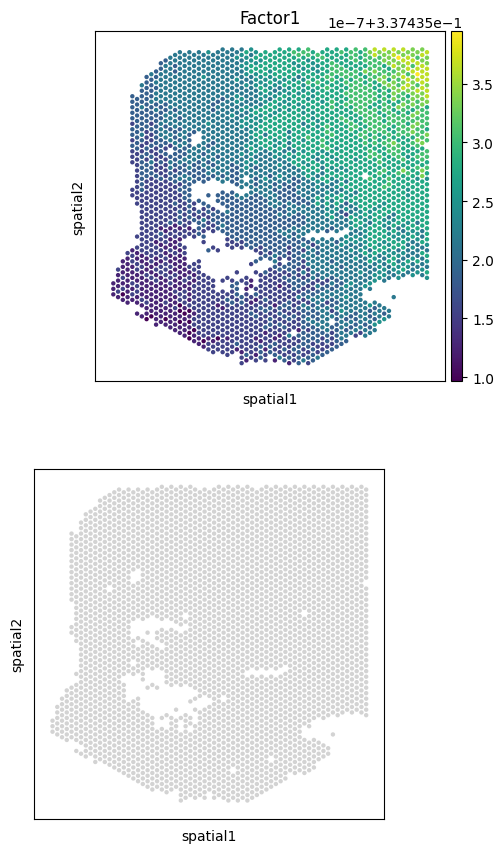

In [15]:
%matplotlib inline
sc.pl.spatial(nmf, color=[*nmf.var.index, None], size=1.4, ncols=1,spot_size=0.01)
plt.ticklabel_format(

In [ ]:
dd